In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import date
import seaborn as sns
from datetime import date, timedelta, datetime
import os
import common_functions as cf

In [119]:
downloads_path = "C:\\Users\\Hannah Nevel\\Downloads"

# define file paths and import data as dataframes
investments_filepath = downloads_path + "\\CM Report  Year to Date Investments-2024-02-21-08-06-55.xlsx"
conversions_filepath = downloads_path+ "\\Year to Date Conversions Schedule-2024-02-21-08-06-51.xlsx"
phoneburner_YTD_filepath = downloads_path + "\\usage 2-21-2024.csv"
newlead_count_filepath = downloads_path +  "\\Year to Date New Leads-2024-02-21-08-06-59.xlsx"
touched_count_filepath = downloads_path + "\\CM Report  Year to Date Accts Touched-2024-02-21-08-07-01.xlsx"
calendly_past_filepath = downloads_path + "\\events-export 2-21-2024.csv"

# phoneburner_ytd_filepath = downloads_path + "\\usage2.csv"


yearly_investment_data = pd.read_excel(investments_filepath)
ytd_conversion_list = pd.read_excel(conversions_filepath)
yearly_loaded_phone_data = pd.read_csv(phoneburner_YTD_filepath)
# yearly_phone_data = pd.read_csv(phoneburner_ytd_filepath)
yearly_newlead_data = pd.read_excel(newlead_count_filepath)
yearly_acctstouched_data = pd.read_excel(touched_count_filepath)
calendly_past = pd.read_csv(calendly_past_filepath)

c:\Users\Hannah Nevel\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Hannah Nevel\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Hannah Nevel\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Hannah Nevel\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no de

In [120]:
yearly_loaded_phone_data['Notes'] = yearly_loaded_phone_data['Notes'].astype(str)

In [121]:
yearly_investment_data = yearly_investment_data[(yearly_investment_data['Account Name'] != 'Andrew Howard') & (yearly_investment_data['Account Name'] != 'Shelley Birmingham')]


In [122]:
#clean and format data
yearly_investment_data['Signature Date'] = pd.to_datetime(yearly_investment_data['Signature Date'])
yearly_investment_data['Investment: Created Date'] = pd.to_datetime(yearly_investment_data['Investment: Created Date'])
yearly_investment_data['Escrow Funds Received'] = pd.to_datetime(yearly_investment_data['Escrow Funds Received'])
yearly_investment_data['Close Date'] = pd.to_datetime(yearly_investment_data['Close Date'])

calendly_past['Start Date & Time'] = pd.to_datetime(calendly_past['Start Date & Time']).dt.date.astype('datetime64')
calendly_past = calendly_past.loc[(calendly_past['User Name'] != 'Matt Willer')]
calendly_past.rename(mapper={'User Name':'User'}, axis=1, inplace=True)
yearly_loaded_phone_data['Duration'] = yearly_loaded_phone_data['Duration'].str.replace(' min','')
yearly_loaded_phone_data['Duration'] = yearly_loaded_phone_data['Duration'].str.replace(' sec','')
yearly_loaded_phone_data['Duration'] = pd.to_numeric(yearly_loaded_phone_data['Duration'])

yearly_investment_data = yearly_investment_data[yearly_investment_data['Investment Owner'] != 'Matt Willer']
yearly_loaded_phone_data = yearly_loaded_phone_data[yearly_loaded_phone_data['User'] != 'Sean Goodnight']

yearly_investment_data['Conversion Check'] = yearly_investment_data['Investment Id'].isin(ytd_conversion_list['Conversion Child ID'])
conversions = yearly_investment_data[yearly_investment_data['Conversion Check'] == True]
rollovers = yearly_investment_data[(yearly_investment_data['Payment Method'] == 'Existing Investment')]
redemptions = yearly_investment_data[(yearly_investment_data['Stage'] == 'Early Redemption') & (yearly_investment_data['Conversion Child ID'] == '')]
yearly_investment_data = yearly_investment_data[(yearly_investment_data['Conversion Check'] == False) & (yearly_investment_data['Payment Method'] != 'Existing Investment') & (yearly_investment_data['Stage'] != 'Early Redemption')]

yearly_investment_data.sort_values(by=['Investment Owner'])
yearly_loaded_phone_data.sort_values(by=['User'])
yearly_newlead_data = yearly_newlead_data[yearly_newlead_data['New Value'] != 'Sean Goodnight']
yearly_newlead_data.sort_values(by=['Investment Owner'])
yearly_acctstouched_data.sort_values(by=['Investment Owner'])

yearly_dialed_phone_data = yearly_loaded_phone_data.loc[(yearly_loaded_phone_data['Notes'] != '' ) & (yearly_loaded_phone_data['Notes'].str.contains('There are no valid phone numbers') == False)\
                                                        & (yearly_loaded_phone_data['Notes'].str.contains("They can't be called at this time") == False)]


In [123]:
yearly_loaded_phone_data['User'].nunique()

7

In [124]:
yearly_dialed_phone_data.shape

(26030, 23)

In [125]:
def insert_investment_data_columns(df):
    if df.shape != (7,3):
        try:
            df['Total Investment','Created']
        except KeyError:
            df['Total Investment','Created'] = [0,0,0,0,0,0,0]
        try:
            df['Total Investment','Funded']
        except KeyError:
            df['Total Investment','Funded'] = [0,0,0,0,0,0,0]
        try:
            df['Total Investment','Settled']
        except KeyError:
            df['Total Investment','Settled'] = [0,0,0,0,0,0,0]
    
    df.sort_index(axis=1, ascending=True, inplace=True)
        
    return df

In [126]:
def check_for_missing_vals_investments(df):
    initials = ['AW','BP','CC','CS','DG','PM','TA']
    for val in initials:
        if df.shape[0] != 7:
            try:
                df.loc[val]
            except KeyError:
                df.loc[val] = [0]*df.shape[1]
    
    return df.sort_index(inplace=True)


In [127]:
def check_sf_phone_for_missing_vals(df):
    col1 = df.columns[0]
    last_index = len(df)
    zeroes_to_add = df.shape[1]
    initials = ['AW','BP','CC','CS','DG','PM','TA']
    for name in initials:
        if name not in df[col1].values:
            new_row = [0] * zeroes_to_add
            new_row[0] = name
            df.loc[last_index] = new_row

            last_index += 1
    df.sort_values(by=col1, inplace=True)

    return df
       

In [128]:
def convert_name(col):
    return col.split()[0][0]+col.split()[1][0]

In [129]:
#convert names to initials
conversions['Investment Owner'] = conversions['Investment Owner'].astype(str)
conversions['Investment Owner'] = conversions['Investment Owner'].apply(lambda x: convert_name(x))

rollovers['Investment Owner'] = rollovers['Investment Owner'].astype(str)
rollovers['Investment Owner'] = rollovers['Investment Owner'].apply(lambda x: convert_name(x))

redemptions['Investment Owner'] = redemptions['Investment Owner'].astype(str)
redemptions['Investment Owner'] = redemptions['Investment Owner'].apply(lambda x: convert_name(x))

yearly_investment_data['Investment Owner'] = yearly_investment_data['Investment Owner'].astype(str)
yearly_investment_data['Investment Owner'] = yearly_investment_data['Investment Owner'].apply(lambda x: convert_name(x))

yearly_loaded_phone_data['User'] = yearly_loaded_phone_data['User'].astype(str)
yearly_loaded_phone_data['User'] = yearly_loaded_phone_data['User'].apply(lambda x: convert_name(x))

yearly_dialed_phone_data['User'] = yearly_dialed_phone_data['User'].astype(str)
yearly_dialed_phone_data['User'] = yearly_dialed_phone_data['User'].apply(lambda x: convert_name(x))

yearly_newlead_data['New Value'] = yearly_newlead_data['New Value'].astype(str)
yearly_newlead_data['New Value'] = yearly_newlead_data['New Value'].apply(lambda x: convert_name(x))

calendly_past['User'] = calendly_past['User'].astype(str)
calendly_past['User'] = calendly_past['User'].apply(lambda x: convert_name(x))

yearly_acctstouched_data['Edited By'] = yearly_acctstouched_data['Edited By'].astype(str)
yearly_acctstouched_data['Edited By'] = yearly_acctstouched_data['Edited By'].apply(lambda x: convert_name(x))
calendly_past.loc[calendly_past['User'] == 'DS', 'User'] = 'DG'

C:\Users\Hannah Nevel\AppData\Local\Temp\ipykernel_38900\68692831.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_dialed_phone_data['User'] = yearly_dialed_phone_data['User'].astype(str)
C:\Users\Hannah Nevel\AppData\Local\Temp\ipykernel_38900\68692831.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_dialed_phone_data['User'] = yearly_dialed_phone_data['User'].apply(lambda x: convert_name(x))


In [130]:
#convert date columns to datetime

yearly_loaded_phone_data['Date'] = pd.to_datetime(yearly_loaded_phone_data['Date'])
yearly_dialed_phone_data['Date'] = pd.to_datetime(yearly_dialed_phone_data['Date'])
yearly_newlead_data['Edit Date'] = pd.to_datetime(yearly_newlead_data['Edit Date']).dt.normalize()
yearly_acctstouched_data['Edit Date'] = pd.to_datetime(yearly_acctstouched_data['Edit Date']).dt.normalize()

C:\Users\Hannah Nevel\AppData\Local\Temp\ipykernel_38900\156677092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_dialed_phone_data['Date'] = pd.to_datetime(yearly_dialed_phone_data['Date'])


In [131]:
#filter yearly data for yesterdays data
date_obj = date.today()
last_friday = date_obj - timedelta(days=3)
monday = date_obj - timedelta(days=date_obj.weekday())
if date_obj == monday:
    graph_yesterday = False
    fridays_investment_data = yearly_investment_data[((yearly_investment_data['Investment: Created Date'].dt.date == last_friday) & (yearly_investment_data['Stage'] == 'Created'))\
                                                            | ((yearly_investment_data['Escrow Funds Received'].dt.date == last_friday) &(yearly_investment_data['Stage'] == 'Funded'))\
                                                                | ((yearly_investment_data['Close Date'].dt.date == last_friday) & (yearly_investment_data['Stage'] == 'Settled'))]

    fridays_loaded_phone_data = yearly_loaded_phone_data[(yearly_loaded_phone_data['Date'].dt.date == last_friday)]
    fridays_dialed_phone_data = yearly_dialed_phone_data[(yearly_dialed_phone_data['Date'].dt.date == last_friday)]
    fridays_newlead_data = yearly_newlead_data[(yearly_newlead_data['Edit Date'].dt.date == last_friday)]
    fridays_acct_data = yearly_acctstouched_data[(yearly_acctstouched_data['Edit Date'].dt.date == last_friday)]
    fridays_calendlys = calendly_past[(calendly_past['Start Date & Time'].dt.date == last_friday)]
else:
    graph_yesterday = True
    yesterday = date.today() - timedelta(days=1)
    yesterdays_investment_data = yearly_investment_data[((yearly_investment_data['Investment: Created Date'].dt.date == yesterday) & (yearly_investment_data['Stage'] == 'Created'))\
                                                         | ((yearly_investment_data['Escrow Funds Received'].dt.date == yesterday) &(yearly_investment_data['Stage'] == 'Funded'))\
                                                              | ((yearly_investment_data['Close Date'].dt.date == yesterday) & (yearly_investment_data['Stage'] == 'Settled'))]

    yesterdays_loaded_phone_data = yearly_loaded_phone_data[(yearly_loaded_phone_data['Date'].dt.date == yesterday)]
    yesterdays_dialed_phone_data = yearly_dialed_phone_data[(yearly_dialed_phone_data['Date'].dt.date == yesterday)]
    
    yesterdays_newlead_data = yearly_newlead_data[(yearly_newlead_data['Edit Date'].dt.date == yesterday)]
    yesterdays_acct_data = yearly_acctstouched_data[(yearly_acctstouched_data['Edit Date'].dt.date == yesterday)]
    yesterdays_calendlys = calendly_past[(calendly_past['Start Date & Time'].dt.date == yesterday)]


In [132]:
last_friday

datetime.date(2024, 2, 18)

In [133]:
date_obj = date.today()
monday = date_obj - timedelta(days=date_obj.weekday())  # assuming start of week is Monday
current_week = []
for i in range(7):
    current_week.append((monday + timedelta(days=i)).strftime("%Y-%m-%d"))



In [134]:
#filter yearly data for week to date data
weekly_investment_data = yearly_investment_data[((yearly_investment_data['Investment: Created Date'].isin(current_week))&(yearly_investment_data['Stage'] == 'Created'))\
                                                 | ((yearly_investment_data['Escrow Funds Received'].isin(current_week))&(yearly_investment_data['Stage'] == 'Funded')) | \
                                                    ((yearly_investment_data['Close Date'].isin(current_week))&(yearly_investment_data['Stage'] == 'Settled'))]

weekly_loaded_phone_data = yearly_loaded_phone_data[(yearly_loaded_phone_data['Date'].isin(current_week))]
weekly_dialed_phone_data = yearly_dialed_phone_data[(yearly_dialed_phone_data['Date'].isin(current_week))]
weekly_newlead_data = yearly_newlead_data[(yearly_newlead_data['Edit Date'].isin(current_week))]
weekly_acct_data = yearly_acctstouched_data[(yearly_acctstouched_data['Edit Date'].isin(current_week))]
weekly_calendlys = calendly_past[(calendly_past['Start Date & Time'].isin(current_week))]

In [135]:
#filter yearly data for month to date data 
current_month = datetime.now().month
monthly_investment_data =  yearly_investment_data[((yearly_investment_data['Investment: Created Date'].dt.month == current_month)&(yearly_investment_data['Stage'] == 'Created'))\
                                                   | ((yearly_investment_data['Escrow Funds Received'].dt.month == current_month)&(yearly_investment_data['Stage'] == 'Funded'))\
                                                      | ((yearly_investment_data['Close Date'].dt.month == current_month)&(yearly_investment_data['Stage'] == 'Settled'))]

monthly_newlead_data = yearly_newlead_data[(yearly_newlead_data['Edit Date'].dt.month == current_month)]
monthly_acct_data = yearly_acctstouched_data[(yearly_acctstouched_data['Edit Date'].dt.month == current_month)]
monthly_calendlys = calendly_past[(calendly_past['Start Date & Time'].dt.month == current_month)]
monthly_loaded_phone_data = yearly_loaded_phone_data[(yearly_loaded_phone_data['Date'].dt.month == current_month)]
monthly_dialed_phone_data = yearly_dialed_phone_data[(yearly_dialed_phone_data['Date'].dt.month == current_month)]

In [136]:
#daily groupings 
if graph_yesterday == True:
    daily_grouped_loaded_phone_data = yesterdays_loaded_phone_data.groupby('User').agg({'Phone':'nunique','Live Answer':'sum'}).reset_index()
    daily_grouped_dialed_phone_data = yesterdays_dialed_phone_data.groupby('User').agg({'Phone':'nunique'}).reset_index()
    daily_grouped_phone_data = daily_grouped_loaded_phone_data.merge(daily_grouped_dialed_phone_data, how='outer', on='User')

    daily_grouped_calendlys = yesterdays_calendlys.groupby('User')['Invitee Email'].nunique().reset_index()

    daily_grouped_investment_data = yesterdays_investment_data.groupby(['Investment Owner','Stage']).agg({'Total Investment': 'sum'}).unstack("Stage").fillna(0)
    check_for_missing_vals_investments(daily_grouped_investment_data)

    insert_investment_data_columns(daily_grouped_investment_data)
    daily_grouped_discounts = yesterdays_investment_data.groupby('Investment Owner').agg({'Discounted Bond?':'count'}).fillna(0)
    # daily_grouped_investment_data = daily_grouped_investment_data.merge(daily_grouped_discounts, on='Investment Owner', how='outer')

    daily_grouped_lead_data = yesterdays_newlead_data.groupby('New Value').agg({'Account ID':'nunique'}).reset_index()
    daily_grouped_lead_data.rename(mapper={'New Value':'Edited By'}, axis=1, inplace=True)
    daily_grouped_acct_data = yesterdays_acct_data.groupby('Edited By').agg({'Account ID':'nunique'}).reset_index()

    check_sf_phone_for_missing_vals(daily_grouped_lead_data)
    check_sf_phone_for_missing_vals(daily_grouped_acct_data)
    check_sf_phone_for_missing_vals(daily_grouped_phone_data)
    check_sf_phone_for_missing_vals(daily_grouped_calendlys)

    daily_grouped_phone_data = daily_grouped_phone_data.merge(daily_grouped_calendlys, on='User', how='outer').fillna(0)
    daily_grouped_phone_data.rename(mapper={'Invitee Email':'Calendlys','Phone_x':'Numbers Loaded','Phone_y':'Numbers Dialed'}, axis=1, inplace=True)
    
    daily_sf_data = daily_grouped_acct_data.merge(daily_grouped_lead_data, on = 'Edited By', how='outer')
    daily_sf_data.rename(mapper={'Account ID_x':'Accts Touched','Account ID_y':'New Leads'}, axis=1, inplace=True)
elif graph_yesterday == False:
    daily_grouped_loaded_phone_data = fridays_loaded_phone_data.groupby('User').agg({'Phone':'nunique','Live Answer':'sum'}).reset_index()
    daily_grouped_dialed_phone_data = fridays_dialed_phone_data.groupby('User').agg({'Phone':'nunique'}).reset_index()
    daily_grouped_phone_data = daily_grouped_loaded_phone_data.merge(daily_grouped_dialed_phone_data, how='outer', on='User')

    daily_grouped_calendlys = fridays_calendlys.groupby('User')['Invitee Email'].nunique().reset_index()

    daily_grouped_investment_data = fridays_investment_data.groupby(['Investment Owner','Stage']).agg({'Total Investment': 'sum'}).unstack("Stage").fillna(0)
    check_for_missing_vals_investments(daily_grouped_investment_data)
    insert_investment_data_columns(daily_grouped_investment_data)
    daily_grouped_discounts = fridays_investment_data.groupby('Investment Owner').agg({'Discounted Bond?':'count'}).fillna(0)
    # daily_grouped_investment_data = daily_grouped_investment_data.merge(daily_grouped_discounts, on='Investment Owner', how='outer')

    daily_grouped_lead_data = fridays_newlead_data.groupby('New Value').agg({'Account ID':'nunique'}).reset_index()
    daily_grouped_lead_data.rename(mapper={'New Value':'Edited By'}, axis=1, inplace=True)
    daily_grouped_acct_data = fridays_acct_data.groupby('Edited By').agg({'Account ID':'nunique'}).reset_index()
    
    check_sf_phone_for_missing_vals(daily_grouped_lead_data)
    check_sf_phone_for_missing_vals(daily_grouped_acct_data)
    check_sf_phone_for_missing_vals(daily_grouped_phone_data)
    check_sf_phone_for_missing_vals(daily_grouped_calendlys)

    daily_grouped_phone_data = daily_grouped_phone_data.merge(daily_grouped_calendlys, on='User', how='outer').fillna(0)
    daily_grouped_phone_data.rename(mapper={'Invitee Email':'Calendlys','Phone_x':'Numbers Loaded','Phone_y':'Numbers Dialed'}, axis=1, inplace=True)
    
    daily_sf_data = daily_grouped_acct_data.merge(daily_grouped_lead_data, on = 'Edited By', how='outer')
    daily_sf_data.rename(mapper={'Account ID_x':'Accts Touched','Account ID_y':'New Leads'}, axis=1, inplace=True)


In [137]:
daily_sf_data

,Edited By,Accts Touched,New Leads
0,AW,194,51
1,BP,130,48
2,CC,115,50
3,CS,123,46
4,DG,38,68
5,PM,98,50
6,TA,119,50


In [138]:
conversions_grouped = conversions.groupby(['Investment Owner','Stage']).agg({'Total Investment': 'sum'}).unstack('Stage').fillna(0)
rollovers_grouped = rollovers.groupby(['Investment Owner','Stage']).agg({'Total Investment': 'sum'}).unstack('Stage').fillna(0)
redemptions_grouped = redemptions.groupby(['Investment Owner','Stage']).agg({'Total Investment': 'sum'}).unstack('Stage').fillna(0)

rollovers_conversions_redemps = conversions_grouped.merge(rollovers_grouped, on='Investment Owner', how='outer').merge(redemptions_grouped, on='Investment Owner', how='outer').fillna(0)
rollovers_conversions_redemps.rename(mapper={'Total Investment_x':'Conversions','Total Investment_y':'Rollovers','Total Investment':'Redemptions'}, inplace=True, axis=1)

In [139]:
rollovers_conversions_redemps

Conversions            Rollovers           
Stage                Created    Settled   Created    Settled
Investment Owner                                            
AW                       0.0     5000.0       0.0        0.0
BP                  853000.0  1009000.0    1000.0   200000.0
CC                       0.0   155000.0       0.0        0.0
CS                  758000.0   657000.0   70000.0  1069000.0

In [140]:
def format_number(value):
    if value >= 1e6:
        return '{:.1f}M'.format(value / 1e6)
    elif value >= 1e3:
        return '{:.0f}K'.format(value / 1e3)
    else:
        return str(value)

In [141]:
def format_bar_labels_currency(plot,i):
    label=[]
    try:
        for num in plot.containers[i].datavalues:
            if num != 0 and num != '':
                label.append(format_number(num))
            else:
                label.append('')
        plot.bar_label(plot.containers[i], labels=label, fontsize=6.5)
    except IndexError:
        x = None
    

    return label

In [142]:
daily_grouped_dialed_phone_data

,User,Phone
0,AW,181
1,BP,104
2,CC,117
3,CS,116
4,DG,35
5,PM,85
6,TA,113


In [143]:
daily_grouped_loaded_phone_data

,User,Phone,Live Answer
0,AW,182,34
1,BP,107,26
2,CC,117,29
3,CS,120,35
4,DG,35,6
5,PM,94,19
6,TA,113,22


In [144]:
#weekly groupings 
weekly_grouped_loaded_phone_data = weekly_loaded_phone_data.groupby('User').agg({'Phone':'nunique','Live Answer':'sum'}).reset_index()
weekly_grouped_dialed_phone_data = weekly_dialed_phone_data.groupby('User').agg({'Phone':'nunique'}).reset_index()
weekly_grouped_phone_data = weekly_grouped_loaded_phone_data.merge(weekly_grouped_dialed_phone_data, how='outer', on='User')
weekly_grouped_calendlys = weekly_calendlys.groupby('User')['Invitee Email'].nunique().reset_index()

weekly_grouped_investment_data = weekly_investment_data.groupby(['Investment Owner','Stage']).agg({'Total Investment': 'sum'}).unstack("Stage").fillna(0)
check_for_missing_vals_investments(weekly_grouped_investment_data)
insert_investment_data_columns(weekly_grouped_investment_data)
weekly_grouped_discounts = weekly_investment_data.groupby('Investment Owner').agg({'Discounted Bond?':'count'}).fillna(0)
# weekly_grouped_investment_data = weekly_grouped_investment_data.merge(weekly_grouped_discounts, on='Investment Owner', how='outer').fillna(0)

weekly_grouped_lead_data = weekly_newlead_data.groupby('New Value').agg({'Account ID':'nunique'}).reset_index()
weekly_grouped_acct_data = weekly_acct_data.groupby('Edited By').agg({'Account ID':'nunique'}).reset_index()

check_sf_phone_for_missing_vals(weekly_grouped_lead_data)
check_sf_phone_for_missing_vals(weekly_grouped_acct_data)
check_sf_phone_for_missing_vals(weekly_grouped_phone_data)
check_sf_phone_for_missing_vals(weekly_grouped_calendlys)

weekly_grouped_phone_data = weekly_grouped_phone_data.merge(weekly_grouped_calendlys, on='User', how='outer').fillna(0)
weekly_grouped_phone_data.rename(mapper={'Invitee Email':'Calendlys','Phone_x':'Numbers Loaded','Phone_y':'Numbers Dialed'}, axis=1, inplace=True)

weekly_sf_data = pd.concat([weekly_grouped_acct_data,weekly_grouped_lead_data], axis=1)

In [145]:
#monthly groupings

monthly_grouped_loaded_phone_data = monthly_loaded_phone_data.groupby('User').agg({'Phone':'nunique','Live Answer':'sum'}).reset_index()
monthly_grouped_dialed_phone_data = monthly_dialed_phone_data.groupby('User').agg({'Phone':'nunique'}).reset_index()
monthly_grouped_phone_data = monthly_grouped_loaded_phone_data.merge(monthly_grouped_dialed_phone_data, how='outer', on='User')
monthly_grouped_calendlys = monthly_calendlys.groupby('User')['Invitee Email'].nunique().reset_index()
monthly_grouped_investment_data = monthly_investment_data.groupby(['Investment Owner','Stage']).agg({'Total Investment': 'sum'}).unstack('Stage').fillna(0)
monthly_grouped_lead_data = monthly_newlead_data.groupby('New Value').agg({'Account ID':'nunique'}).reset_index()
monthly_grouped_acct_data = monthly_acct_data.groupby('Edited By').agg({'Account ID':'nunique'}).reset_index()

check_sf_phone_for_missing_vals(monthly_grouped_lead_data)
check_sf_phone_for_missing_vals(monthly_grouped_acct_data)
check_sf_phone_for_missing_vals(monthly_grouped_phone_data)
check_sf_phone_for_missing_vals(monthly_grouped_calendlys)

monthly_grouped_phone_data = monthly_grouped_phone_data.merge(monthly_grouped_calendlys, on='User', how='outer').fillna(0)
monthly_grouped_phone_data.rename(mapper={'Invitee Email':'Calendlys','Phone_x':'Numbers Loaded','Phone_y':'Numbers Dialed'}, axis=1, inplace=True)

monthly_sf_data = pd.concat([monthly_grouped_acct_data,monthly_grouped_lead_data], axis=1)

In [146]:
#yearly groupings 
yearly_grouped_loaded_phone_data = yearly_loaded_phone_data.groupby('User').agg({'Phone':'nunique','Live Answer':'sum'}).reset_index()
yearly_grouped_dialed_phone_data = yearly_dialed_phone_data.groupby('User').agg({'Phone':'nunique'}).reset_index()
yearly_grouped_phone_data = yearly_grouped_loaded_phone_data.merge(yearly_grouped_dialed_phone_data, how='outer', on='User')

yearly_grouped_calendlys = calendly_past.groupby('User')['Invitee Email'].nunique().reset_index()
yearly_grouped_investment_data = yearly_investment_data.groupby(['Investment Owner','Stage']).agg({'Total Investment': 'sum'}).unstack('Stage').fillna(0).reset_index()
yearly_grouped_lead_data = yearly_newlead_data.groupby('New Value').agg({'Account ID':'nunique'}).reset_index()
yearly_grouped_acct_data = yearly_acctstouched_data.groupby('Edited By').agg({'Account ID':'nunique'}).reset_index()

yearly_grouped_phone_data = yearly_grouped_phone_data.merge(yearly_grouped_calendlys, on='User', how='outer').fillna(0)
yearly_grouped_phone_data.rename(mapper={'Invitee Email':'Calendlys','Phone_x':'Numbers Loaded','Phone_y':'Numbers Dialed'}, axis=1, inplace=True)
yearly_sf_data = pd.concat([yearly_grouped_acct_data,yearly_grouped_lead_data], axis=1)


In [147]:
def drop_nans(df):
    length = len(df)
    if length == 8:
        df.drop(labels=7,axis=0,inplace=True)

    return df


In [148]:
# yearly_grouped_lead_data.drop(labels=7,axis=0,inplace=True)
# drop_nans(monthly_grouped_lead_data)

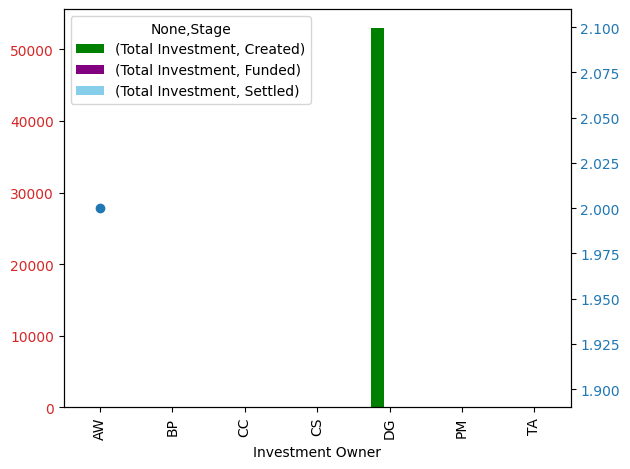

In [149]:
figtest, ax1 = plt.subplots()

color = 'tab:red'


daily_grouped_investment_data.plot.bar(ax=ax1, color=['green','purple','skyblue'])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'

ax2.scatter(daily_grouped_discounts.index,daily_grouped_discounts['Discounted Bond?'])
ax2.tick_params(axis='y', labelcolor=color)

figtest.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [150]:
daily_grouped_phone_data

,User,Numbers Loaded,Live Answer,Numbers Dialed,Calendlys
0,AW,182,34,181,2
1,BP,107,26,104,3
2,CC,117,29,117,0
3,CS,120,35,116,0
4,DG,35,6,35,2
5,PM,94,19,85,0
6,TA,113,22,113,1


In [151]:
daily_grouped_lead_data

,Edited By,Account ID
0,AW,51
1,BP,48
2,CC,50
3,CS,46
4,DG,68
5,PM,50
6,TA,50


In [152]:
weekly_grouped_phone_data

,User,Numbers Loaded,Live Answer,Numbers Dialed,Calendlys
0,AW,306,59,302,8
1,BP,204,40,196,5
2,CC,152,33,147,5
3,CS,234,60,210,0
4,DG,35,6,35,2
5,PM,294,49,279,7
6,TA,113,22,113,1


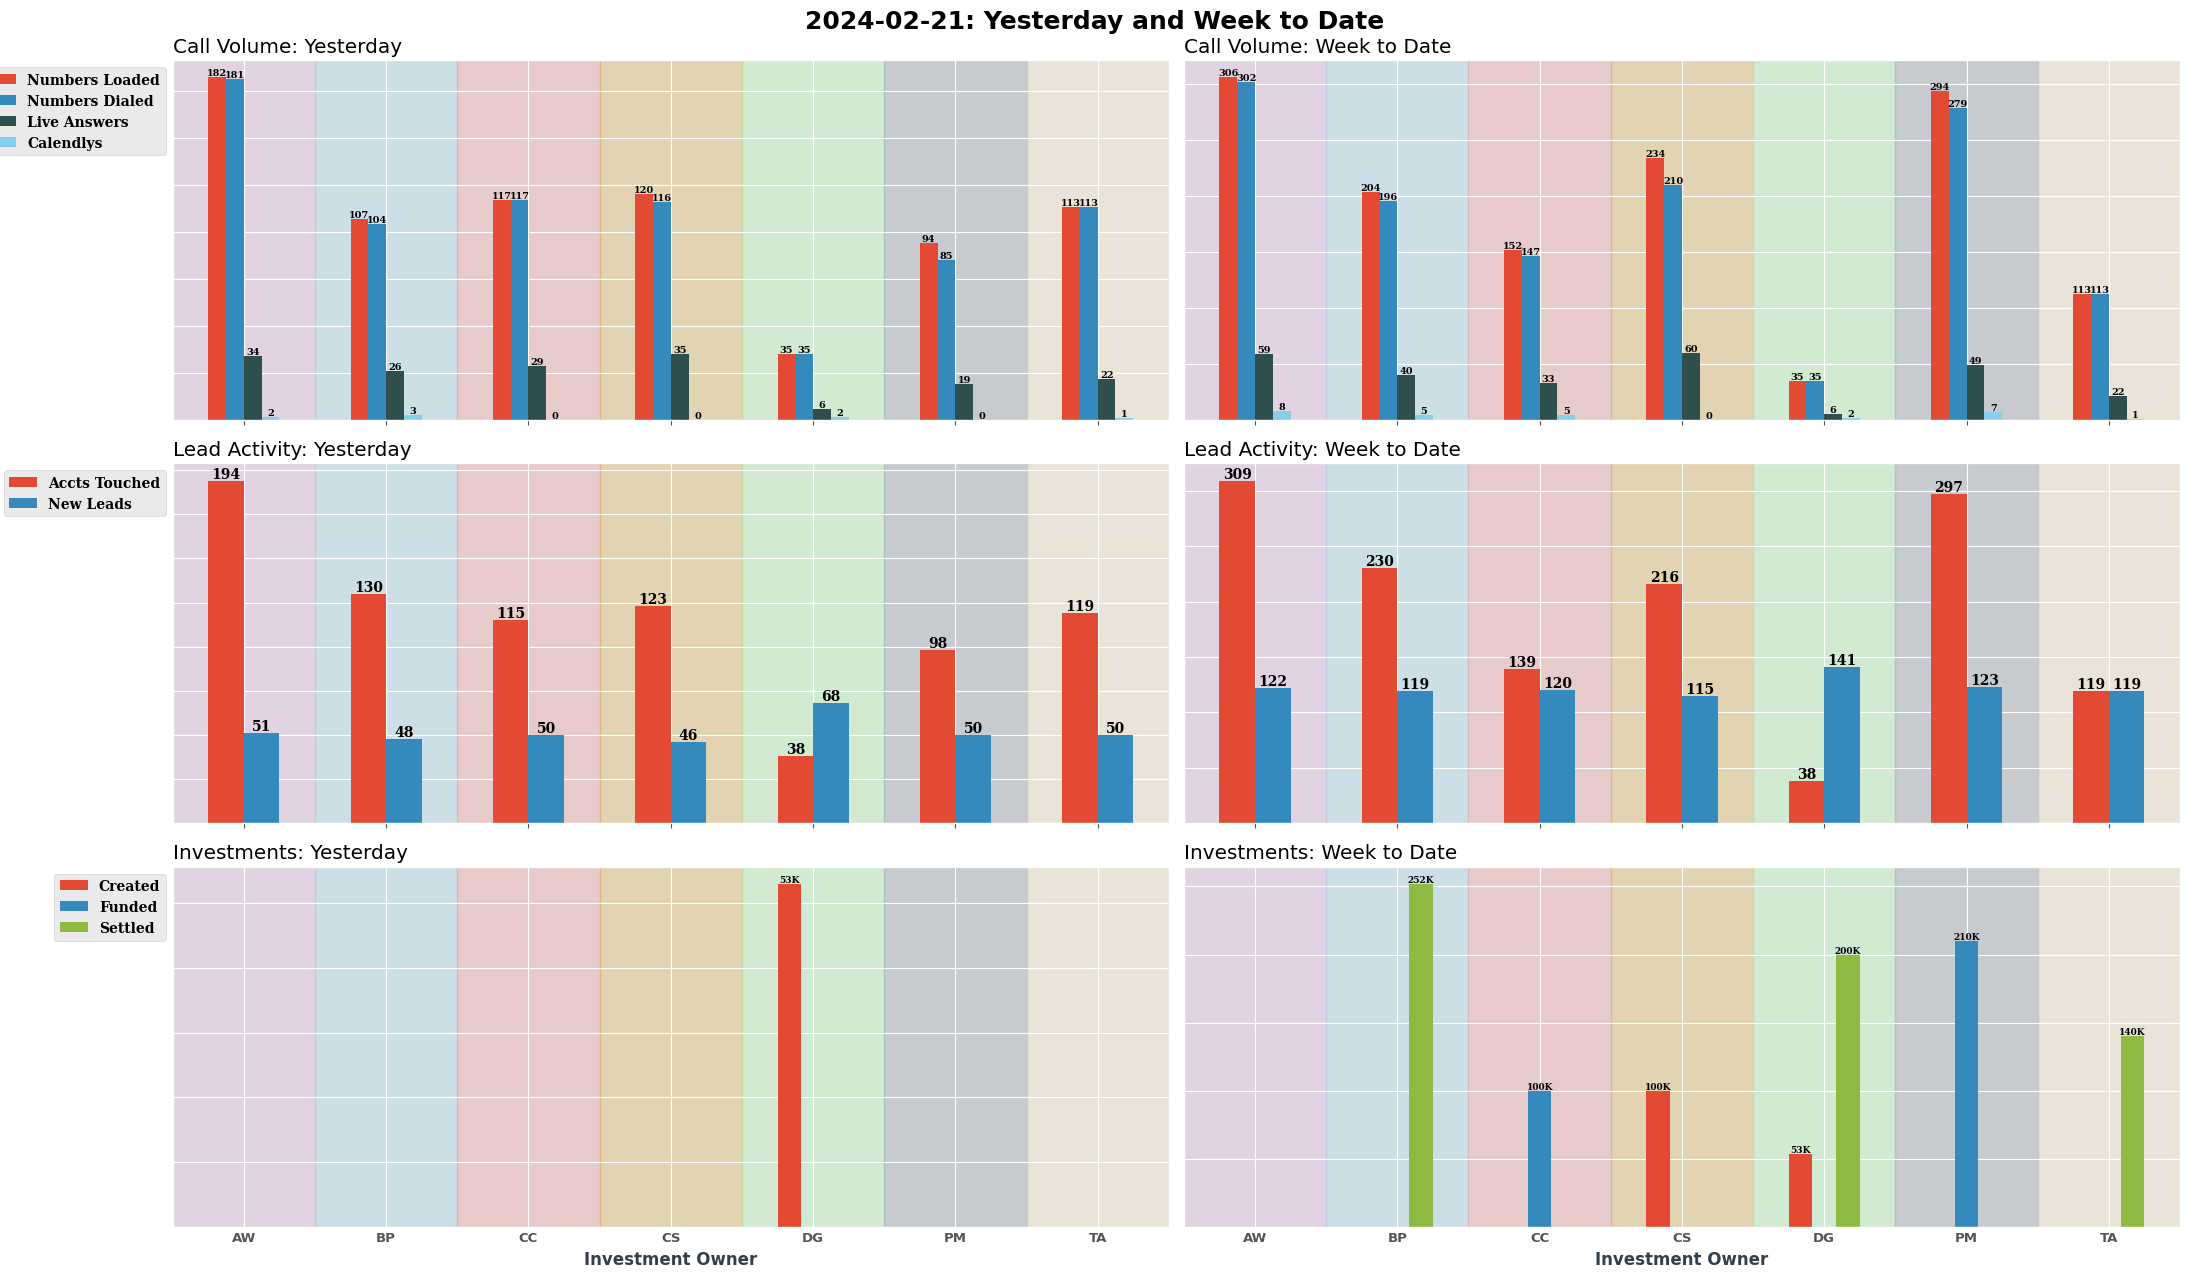

In [153]:
with plt.style.context('ggplot'):

    #define figures, format figures and graph all data
    fig1, axes = plt.subplots(3,2, sharex=True, figsize=(22,13))

    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Helvetica'
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
  
    # plt.rcParams['xtick.color']='#333F4B'
    # plt.rcParams['ytick.color']='#333F4B'
    if graph_yesterday == True:
        title = str(date.today()) + ': Yesterday and Week to Date'
        fig1.suptitle(title, fontweight="extra bold", fontsize=18, fontfamily='DejaVu Sans')
        axes[0,0].set_title('Call Volume: Yesterday', loc='left')
        axes[1,0].set_title('Lead Activity: Yesterday', loc='left')
        axes[2,0].set_title('Investments: Yesterday', loc='left')
    if graph_yesterday == False:
        title = str(date.today()) + ': Friday and Week to Date'
        fig1.suptitle(title, fontweight="extra bold", fontsize=18, fontfamily='DejaVu Sans')
        axes[0,0].set_title('Call Volume: Friday', loc='left')
        axes[1,0].set_title('Lead Activity: Friday', loc='left')
        axes[2,0].set_title('Investments: Friday', loc='left')

    axes[0,1].set_title('Call Volume: Week to Date', loc='left')
    axes[1,1].set_title('Lead Activity: Week to Date', loc='left')
    axes[2,1].set_title('Investments: Week to Date', loc='left')

    fig1.subplots_adjust(hspace=0.4)


            #phone nums daily
    daily_grouped_phone_data.plot.bar(x='User',y=['Numbers Loaded','Numbers Dialed', 'Live Answer','Calendlys'], stacked=False,ax=axes[0,0],color=['#E24A33','#348ABD','darkslategrey','skyblue'])
    axes[0,0].legend(['Numbers Loaded','Numbers Dialed', 'Live Answers','Calendlys'], loc=0)
    axes[0,0].set_ylabel('')
    # axes[0].set_xlabel('')
    axes[0,0].bar_label(axes[0,0].containers[0],fontsize=7)
    axes[0,0].bar_label(axes[0,0].containers[1], fontsize=7)
    axes[0,0].bar_label(axes[0,0].containers[2], fontsize=7)
    axes[0,0].bar_label(axes[0,0].containers[3], fontsize=7)
    axes[0,0].set(yticklabels=[]) 
    axes[0,0].tick_params(left=False)

    

        #phone nums weekly
    weekly_grouped_phone_data.plot.bar(x='User',y=['Numbers Loaded','Numbers Dialed', 'Live Answer','Calendlys'], stacked=False,ax=axes[0,1],legend=None,color=['#E24A33','#348ABD','darkslategrey','skyblue'])
    axes[0,1].set_ylabel('')
    # axes[1].set_xlabel('')
    axes[0,1].bar_label(axes[0,1].containers[0],fontsize=7)
    axes[0,1].bar_label(axes[0,1].containers[1], fontsize=7)
    axes[0,1].bar_label(axes[0,1].containers[2], fontsize=7)
    axes[0,1].bar_label(axes[0,1].containers[3], fontsize=7)
    axes[0,1].set(yticklabels=[]) 
    axes[0,1].tick_params(left=False)
    
        #sf data daily
    daily_sf_data.plot.bar(x='Edited By',y=['Accts Touched','New Leads'],stacked=False,ax=axes[1,0])
    axes[1,0].legend(['Accts Touched','New Leads'], loc=0)
    axes[1,0].set_ylabel('')
    # axes[1].set_xlabel('')
    axes[1,0].bar_label(axes[1,0].containers[0], fontsize=10)
    axes[1,0].bar_label(axes[1,0].containers[1], fontsize=10)
    axes[1,0].set(yticklabels=[]) 
    axes[1,0].tick_params(left=False)

        #sf data weekly
    weekly_sf_data['Account ID'].plot.bar(stacked=False,ax=axes[1,1], legend=None)
    axes[1,1].set_ylabel('')
    # axes[1].set_xlabel('')
    axes[1,1].bar_label(axes[1,1].containers[0], fontsize=10)
    axes[1,1].bar_label(axes[1,1].containers[1], fontsize=10)
    axes[1,1].set(yticklabels=[]) 
    axes[1,1].tick_params(left=False)

        #investment daily
    daily_grouped_investment_data['Total Investment'].plot.bar(stacked=False, ax=axes[2,0], color=['#E24A33','#348ABD','#8EBA42'])

    # ax2 = axes[2,0].twinx()# instantiate a second axes that shares the same x-axis
    # ax2.legend()

    # ax2.scatter(daily_grouped_discounts.index,daily_grouped_discounts['Discounted Bond?'], color='orange', label='Discounts')

    axes[2,0].tick_params(labelrotation=0, labelsize = 9.5, labelfontfamily='DejaVu Sans', reset=True, length=0)
    axes[2,0].legend()
    axes[2,0].set_ylabel('')
    # axes[2].yaxis.set_major_formatter('${x:,.0f}')
    # axes[2].set_ylim(bottom=0, top=max)
    axes[2,0].set(yticklabels=[]) 
    format_bar_labels_currency(axes[2,0],0)
    format_bar_labels_currency(axes[2,0],1)
    format_bar_labels_currency(axes[2,0],2)


        #investment weekly
    weekly_grouped_investment_data['Total Investment'].plot.bar(stacked=False, ax=axes[2,1], legend=None,color=['#E24A33','#348ABD','#8EBA42'])

    axes[2,1].tick_params(labelrotation=0, labelsize = 9.5, labelfontfamily='DejaVu Sans', reset=True, length=0)
    axes[2,1].set_ylabel('')
    # axes[2].yaxis.set_major_formatter('${x:,.0f}')
    # axes[2].set_ylim(bottom=0, top=max)
    axes[2,1].set(yticklabels=[]) 

    format_bar_labels_currency(axes[2,1],0)
    format_bar_labels_currency(axes[2,1],1)
    format_bar_labels_currency(axes[2,1],2)

    sns.move_legend(axes[0,0], "upper right", bbox_to_anchor=(0, 1))
    sns.move_legend(axes[1,0], "upper right", bbox_to_anchor=(0, 1))
    sns.move_legend(axes[2,0], "upper right", bbox_to_anchor=(0, 1))
    axes[2,0].set_xlabel('Investment Owner', fontsize=12, fontfamily='DejaVu Sans', fontweight='bold', color = '#333F4B')

    # sns.move_legend(axes[0,0], "upper left", bbox_to_anchor=(1, 1))
    # sns.move_legend(axes[1,0], "upper left", bbox_to_anchor=(1, 1))
    # sns.move_legend(axes[2,0], "upper left", bbox_to_anchor=(1, 1))
    axes[2,1].set_xlabel('Investment Owner', fontsize=12, fontfamily='DejaVu Sans', fontweight='bold', color = '#333F4B')

for ax in range(0,3):
    axes[ax,0].axvspan(-1, .5, color='plum', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(.5, 1.5, color='skyblue', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(1.5, 2.5, color='lightcoral', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(2.5, 3.5, color='goldenrod', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(3.5, 4.5, color='palegreen', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(4.5, 5.5, color='slategrey', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(5.5, 6.5, color='wheat', alpha=0.25, zorder=0)

for ax in range(0,1):
    axes[ax,1].axvspan(-1, .5, color='plum', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(.5, 1.5, color='skyblue', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(1.5, 2.5, color='lightcoral', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(2.5, 3.5, color='goldenrod', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(3.5, 4.5, color='palegreen', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(4.5, 5.5, color='slategrey', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(5.5, 6.5, color='wheat', alpha=0.25, zorder=0)

for ax in range(1,2):
    axes[ax,1].axvspan(-1, .5, color='plum', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(.5, 1.5, color='skyblue', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(1.5, 2.5, color='lightcoral', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(2.5, 3.5, color='goldenrod', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(3.5, 4.5, color='palegreen', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(4.5, 5.5, color='slategrey', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(5.5, 6.5, color='wheat', alpha=0.25, zorder=0)

for ax in range(2,3):
    axes[ax,1].axvspan(-1, .5, color='plum', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(.5, 1.5, color='skyblue', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(1.5, 2.5, color='lightcoral', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(2.5, 3.5, color='goldenrod', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(3.5, 4.5, color='palegreen', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(4.5, 5.5, color='slategrey', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(5.5, 6.5, color='wheat', alpha=0.25, zorder=0)

    plt.tight_layout()
    plt.show()

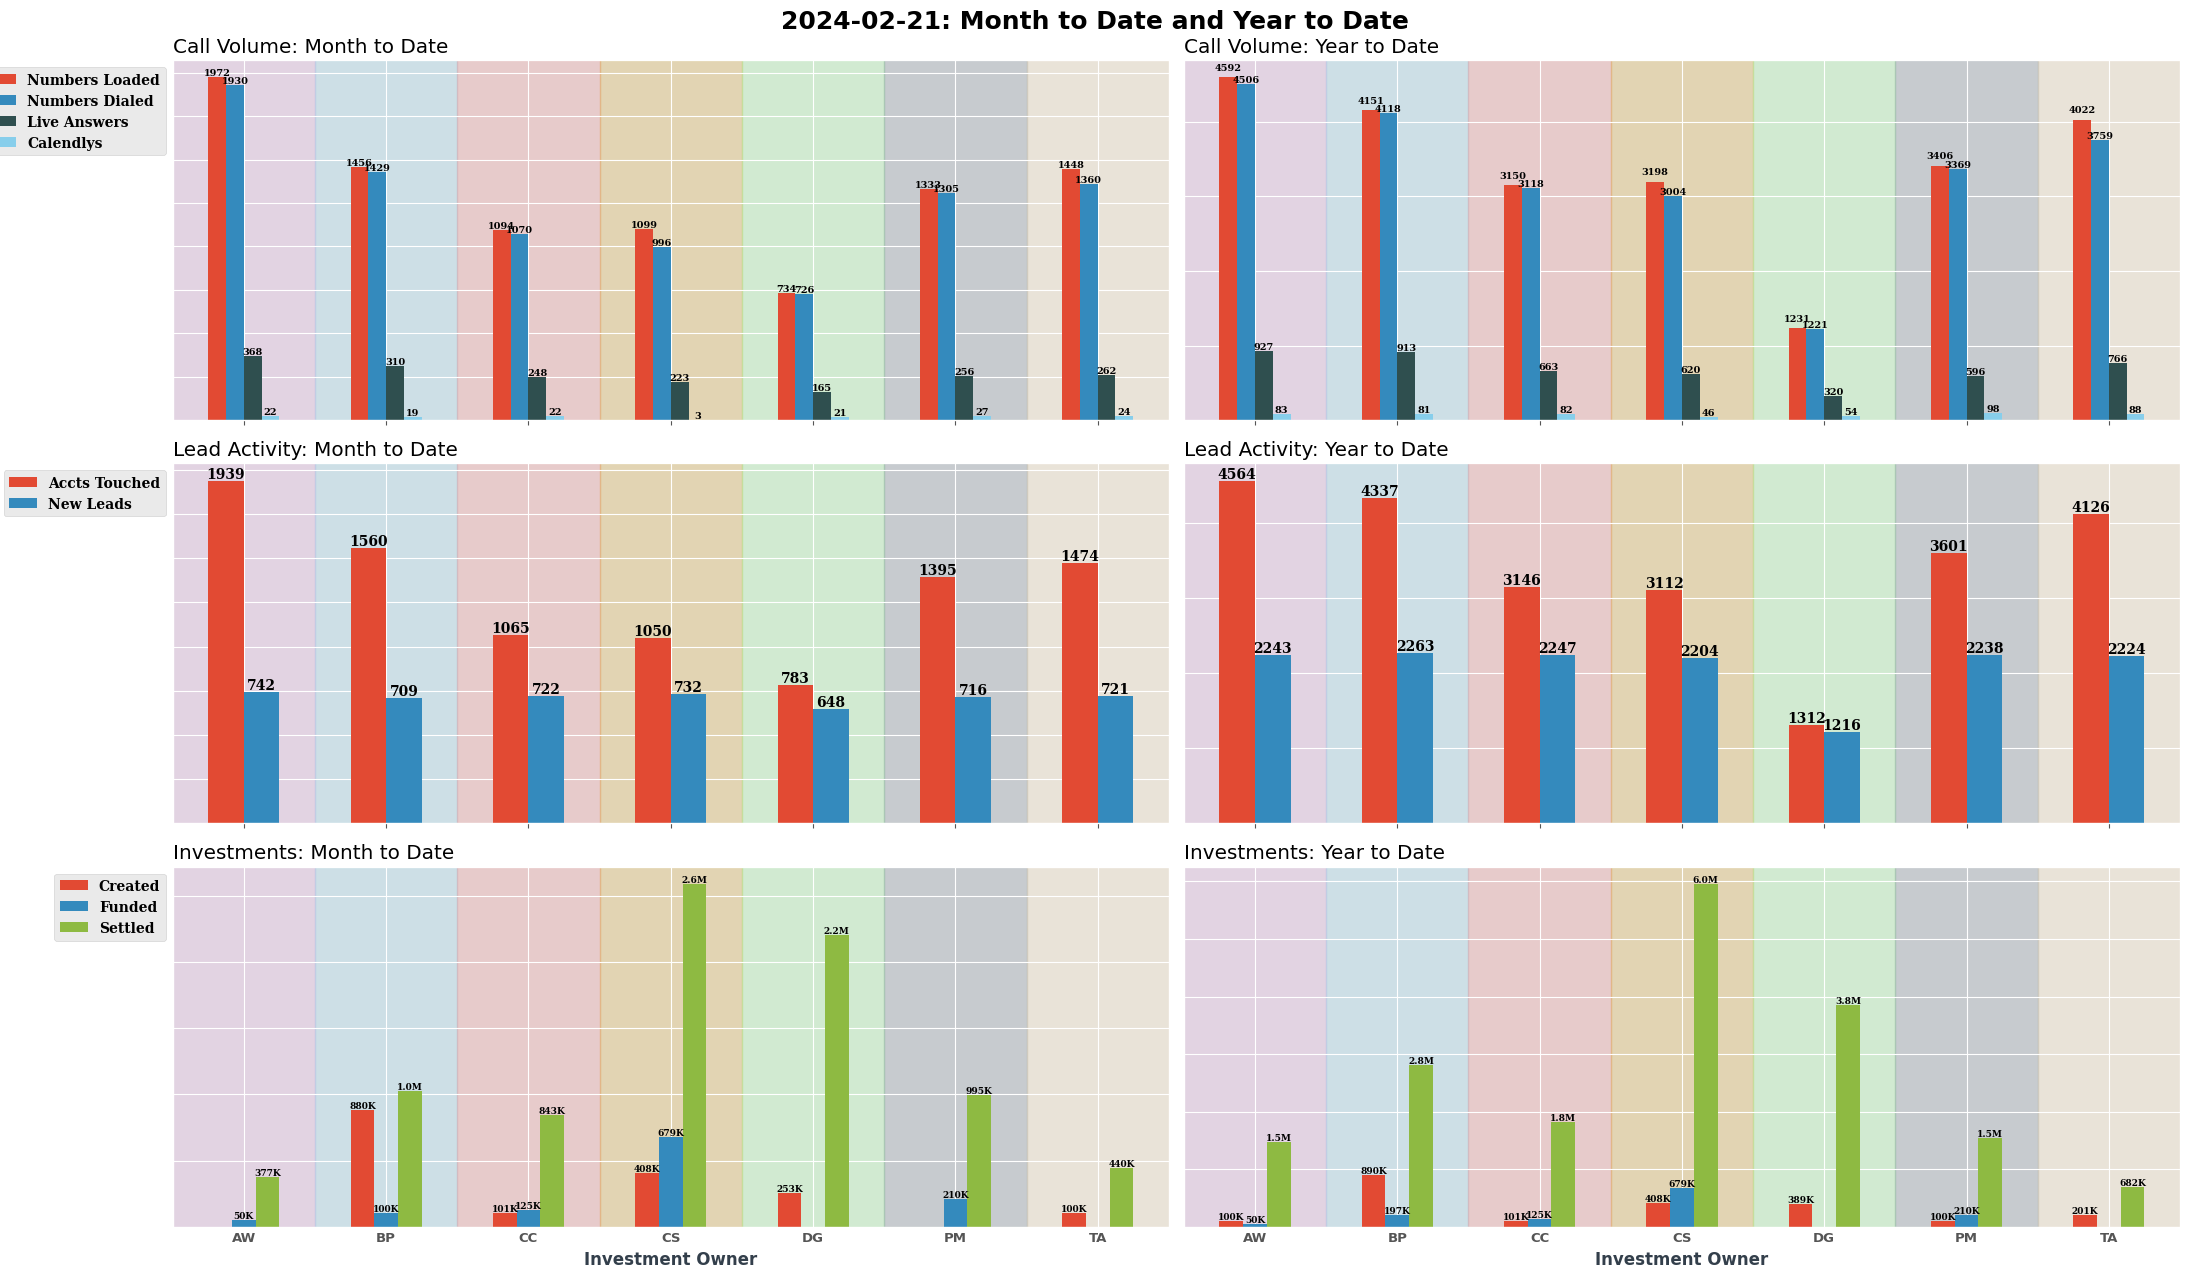

In [154]:
#Month to Date and Year to Date

with plt.style.context('ggplot'):

    #define figures, format figures and graph all data
    fig2, axes = plt.subplots(3,2, sharex=True, figsize=(22,13))

    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Helvetica'
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8

    # plt.rcParams['xtick.color']='#333F4B'
    # plt.rcParams['ytick.color']='#333F4B'
    axes[0,0].set_title('Call Volume: Month to Date', loc='left')
    axes[0,1].set_title('Call Volume: Year to Date', loc='left')
    axes[1,0].set_title('Lead Activity: Month to Date', loc='left')
    axes[1,1].set_title('Lead Activity: Year to Date', loc='left')
    axes[2,0].set_title('Investments: Month to Date', loc='left')
    axes[2,1].set_title('Investments: Year to Date', loc='left')
    title2 = str(date.today()) + ': Month to Date and Year to Date'
    fig2.suptitle(title2, fontweight="extra bold", fontsize=18, fontfamily='DejaVu Sans')
    fig2.subplots_adjust(hspace=0.4)


            #phone nums monthly
    monthly_grouped_phone_data.plot.bar(x='User',y=['Numbers Loaded','Numbers Dialed', 'Live Answer','Calendlys'], stacked=False,ax=axes[0,0],color=['#E24A33','#348ABD','darkslategrey','skyblue'])
    axes[0,0].legend(['Numbers Loaded','Numbers Dialed', 'Live Answers','Calendlys'])
    axes[0,0].set_ylabel('')
    axes[0,0].tick_params(left=False)
    # axes[0].set_xlabel('')
    axes[0,0].bar_label(axes[0,0].containers[0], fontsize=7)
    axes[0,0].bar_label(axes[0,0].containers[1], fontsize=7)
    axes[0,0].bar_label(axes[0,0].containers[2], fontsize=7)
    axes[0,0].bar_label(axes[0,0].containers[3], fontsize=7)
    axes[0,0].set(yticklabels=[]) 

        #phone nums yearly
    yearly_grouped_phone_data.plot.bar(x='User',y=['Numbers Loaded','Numbers Dialed', 'Live Answer','Calendlys'], stacked=False,ax=axes[0,1],legend=None,color=['#E24A33','#348ABD','darkslategrey','skyblue'])
    # axes[0,1].legend(['Numbers Dialed','Live Answers'], loc=0)
    axes[0,1].set_ylabel('')
    axes[0,1].tick_params(left=False)
    # axes[1].set_xlabel('')
    axes[0,1].bar_label(axes[0,1].containers[0], fontsize=7, rotation=0, padding=4)
    axes[0,1].bar_label(axes[0,1].containers[1], fontsize=7, rotation=0)
    axes[0,1].bar_label(axes[0,1].containers[2], fontsize=7, rotation=0)
    axes[0,1].bar_label(axes[0,1].containers[3], fontsize=7, rotation=0)
    axes[0,1].set(yticklabels=[]) 
    
        #sf data monthly
    monthly_sf_data['Account ID'].plot.bar(stacked=False,ax=axes[1,0])
    axes[1,0].legend(['Accts Touched','New Leads'], loc=0)
    axes[1,0].set_ylabel('')
    # axes[1].set_xlabel('')
    axes[1,0].bar_label(axes[1,0].containers[0], fontsize=10)
    axes[1,0].bar_label(axes[1,0].containers[1], fontsize=10)
    axes[1,0].set(yticklabels=[]) 
    axes[1,0].tick_params(left=False)

        #sf data yearly
    yearly_sf_data['Account ID'].plot.bar(stacked=False,ax=axes[1,1], legend=None)
    # axes[1,1].legend(['Accts Touched','New Leads'], loc=0)
    axes[1,1].set_ylabel('')
    # axes[1].set_xlabel('')
    axes[1,1].bar_label(axes[1,1].containers[0], fontsize=10)
    axes[1,1].bar_label(axes[1,1].containers[1], fontsize=10)
    axes[1,1].set(yticklabels=[]) 
    axes[1,1].tick_params(left=False)

        #investment monthly
    monthly_grouped_investment_data['Total Investment'].plot.bar(stacked=False, ax=axes[2,0],  color=['#E24A33','#348ABD','#8EBA42'])

    axes[2,0].tick_params(labelrotation=0, labelsize = 9.5, labelfontfamily='DejaVu Sans', reset=True, length=0)
    axes[2,0].legend()
    axes[2,0].set_ylabel('')
    # axes[2].yaxis.set_major_formatter('${x:,.0f}')
    # axes[2].set_ylim(bottom=0, top=max)
    axes[2,0].set(yticklabels=[]) 
    format_bar_labels_currency(axes[2,0],0)
    format_bar_labels_currency(axes[2,0],1)
    format_bar_labels_currency(axes[2,0],2)

        #investment yearly
    yearly_grouped_investment_data['Total Investment'].plot.bar(stacked=False, ax=axes[2,1], legend=None,color=['#E24A33','#348ABD','#8EBA42'])

    axes[2,1].tick_params(labelrotation=0, labelsize = 9.5, labelfontfamily='DejaVu Sans', reset=True, length=0)
    axes[2,1].set_xticklabels(['AW','BP','CC','CS','DG','PM','TA'])
    # axes[2,1].legend()
    axes[2,1].set_ylabel('')
    # axes[2].yaxis.set_major_formatter('${x:,.0f}')
    # axes[2].set_ylim(bottom=0, top=max)
    axes[2,1].set(yticklabels=[]) 

    format_bar_labels_currency(axes[2,1],0)
    format_bar_labels_currency(axes[2,1],1)
    format_bar_labels_currency(axes[2,1],2)

    sns.move_legend(axes[0,0], "upper right", bbox_to_anchor=(0, 1))
    sns.move_legend(axes[1,0], "upper right", bbox_to_anchor=(0, 1))
    sns.move_legend(axes[2,0], "upper right", bbox_to_anchor=(0, 1))
    axes[2,0].set_xlabel('Investment Owner', fontsize=12, fontfamily='DejaVu Sans', fontweight='bold', color = '#333F4B')

    # sns.move_legend(axes[0,0], "upper left", bbox_to_anchor=(1, 1))
    # sns.move_legend(axes[1,0], "upper left", bbox_to_anchor=(1, 1))
    # sns.move_legend(axes[2,0], "upper left", bbox_to_anchor=(1, 1))
    axes[2,1].set_xlabel('Investment Owner', fontsize=12, fontfamily='DejaVu Sans', fontweight='bold', color = '#333F4B')
for ax in range(0,3):
    axes[ax,0].axvspan(-1, .5, color='plum', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(.5, 1.5, color='skyblue', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(1.5, 2.5, color='lightcoral', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(2.5, 3.5, color='goldenrod', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(3.5, 4.5, color='palegreen', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(4.5, 5.5, color='slategrey', alpha=0.25, zorder=0)
    axes[ax,0].axvspan(5.5, 6.5, color='wheat', alpha=0.25, zorder=0)

for ax in range(0,1):
    axes[ax,1].axvspan(-1, .5, color='plum', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(.5, 1.5, color='skyblue', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(1.5, 2.5, color='lightcoral', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(2.5, 3.5, color='goldenrod', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(3.5, 4.5, color='palegreen', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(4.5, 5.5, color='slategrey', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(5.5, 6.5, color='wheat', alpha=0.25, zorder=0)

for ax in range(1,2):
    axes[ax,1].axvspan(-1, .5, color='plum', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(.5, 1.5, color='skyblue', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(1.5, 2.5, color='lightcoral', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(2.5, 3.5, color='goldenrod', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(3.5, 4.5, color='palegreen', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(4.5, 5.5, color='slategrey', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(5.5, 6.5, color='wheat', alpha=0.25, zorder=0)

for ax in range(2,3):
    axes[ax,1].axvspan(-1, .5, color='plum', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(.5, 1.5, color='skyblue', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(1.5, 2.5, color='lightcoral', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(2.5, 3.5, color='goldenrod', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(3.5, 4.5, color='palegreen', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(4.5, 5.5, color='slategrey', alpha=0.25, zorder=0)
    axes[ax,1].axvspan(5.5, 6.5, color='wheat', alpha=0.25, zorder=0)
    plt.tight_layout()
    plt.show()


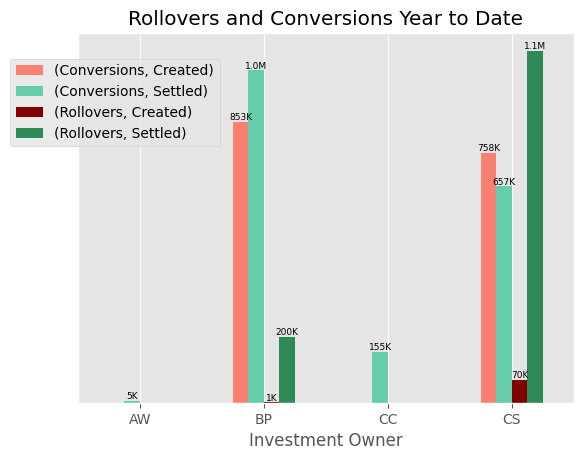

In [155]:
with plt.style.context('ggplot'):   
    fig3, ax = plt.subplots(1) 
    rollovers_conversions_redemps.plot.bar(color=['salmon','mediumaquamarine','maroon','seagreen'], ax=ax)
    plt.legend(loc='upper right', bbox_to_anchor=(0.3, .95))
    plt.title('Rollovers and Conversions Year to Date')
    plt.yticks([])
    plt.xticks(rotation=0)

    format_bar_labels_currency(ax,0)
    format_bar_labels_currency(ax,1)
    format_bar_labels_currency(ax,2)
    format_bar_labels_currency(ax,3)
    plt.show()

In [156]:
def write_unique_file(output_path):
    
    base,ext = os.path.splitext(output_path)
    count = 0
    if os.path.exists(output_path):

        while os.path.exists(output_path):
                count += 1
                output_path = f'{base}_{count}{ext}'
        # print(output_path)
        return output_path
    else:
        # print(output_path)
        return output_path

In [157]:
base_path = 'C:\\Users\\Hannah Nevel\\Documents\\Weekly Reporting - CM\\CM Reports - year to date\\2024\\'
todays_date = str(date.today())
folder_path = cf.create_folder(base_path,todays_date)

In [158]:
todays_date = str(date.today())
save_filename = 'Daily CM Reporting - ' + todays_date + '.pdf'
filepath = folder_path + '\\' +save_filename
unique_filename = cf.write_unique_file(filepath)
with PdfPages(unique_filename) as pdf:
    pdf.savefig(fig1, bbox_inches='tight')
    pdf.savefig(fig2, bbox_inches='tight')
    pdf.savefig(fig3, bbox_inches='tight')

yearly_investment_data.to_excel(folder_path + '\\Investment Data Year to Date - '+ todays_date + '.xlsx',index=False)
ytd_conversion_list.to_excel(folder_path + '\\Conversion Data Year to Date - '+ todays_date+ '.xlsx',index=False)
yearly_loaded_phone_data.to_csv(folder_path + '\\Phone Data Year to Date - '+ todays_date + '.csv',index=False)
# yearly_phone_data = pd.read_csv(phoneburner_yearly_totals_filepath)
yearly_newlead_data.to_excel(folder_path + '\\New Lead Data Year to Date - '+ todays_date + '.xlsx',index=False)
yearly_acctstouched_data.to_excel(folder_path + '\\Accounts Touched Data Year to Date - '+ todays_date + '.xlsx',index=False)
calendly_past.to_csv(folder_path + '\\calendly YTD - ' + todays_date +'.csv', index=False)